In [12]:
import pandas as pd

# utils
import src.utils.visualization.gantt_diagram as gantt
from src.solvers.schedule_converter import get_schedule_dframe
from src.utils.initialization import jobs_jssp_init as init
from src.utils.analysis_basics import check_constraints as check
from src.utils.rolling_process.rolling_filter import *

# solver
from src.solvers.builder import get_job_ops_model_from_dframe
from src.solvers.schedule_converter import get_schedule_dframe
from src.solvers.lp.makespan import solve_jssp_makespan


# simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*3     # 3 min

# Simulation
simulation = ProductionSimulation(sigma = 0.25)

In [3]:
# load file
basic_data_path = get_path("data", "basic")
examples_data_path = get_path("data", "examples")
df_routings = pd.read_csv(basic_data_path / "routings_ft10.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


## I. Generation of job-shop scheduling problem and the associated jobs information

In [4]:
# Generation based on routings and specified parameters, in particular maximum utilization (95%)
df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 1, shift_length = 1440,
                                                        u_b_mmax = 0.95, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
1,J25-0001,6,123,1440
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
5,J25-0005,1,472,1440
...,...,...,...,...
11,J25-0011,1,976,1440
12,J25-0012,2,1045,1440
13,J25-0013,3,1129,1440


## Day 1

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# “new” and unfinished jobs
df_jobs_arrivals_current = get_current_jobs(
    df_jobs_arrivals, df_previous_not_started = None, ready_time=day_start
)
df_jobs_arrivals_current

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
1,J25-0001,6,123,1440
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
5,J25-0005,1,472,1440
...,...,...,...,...
11,J25-0011,1,976,1440
12,J25-0012,2,1045,1440
13,J25-0013,3,1129,1440


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_arrivals_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
164,J25-0016,6,4,M06,32
165,J25-0016,6,5,M05,21
166,J25-0016,6,6,M09,32


### Scheduling

In [8]:
job_ops = get_job_ops_model_from_dframe(df_jssp_current)
job_ops

{'J25-0000': [(0, 'M00', 76),
  (1, 'M01', 69),
  (2, 'M03', 76),
  (3, 'M05', 51),
  (4, 'M02', 85),
  (5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(0, 'M00', 43),
  (1, '

In [20]:
df_jobs_arrivals_current = df_jobs_arrivals_current.sort_values("Arrival", ascending=False).reset_index(drop=True)

arrivals = df_jobs_arrivals_current.set_index("Job")["Arrival"].to_dict()
arrivals

{'J25-0016': 1421,
 'J25-0015': 1361,
 'J25-0014': 1158,
 'J25-0013': 1129,
 'J25-0012': 1045,
 'J25-0011': 976,
 'J25-0010': 971,
 'J25-0009': 951,
 'J25-0008': 936,
 'J25-0007': 877,
 'J25-0006': 749,
 'J25-0005': 472,
 'J25-0004': 271,
 'J25-0003': 231,
 'J25-0002': 187,
 'J25-0001': 123,
 'J25-0000': 75}

In [21]:
schedule = solve_jssp_makespan(
    job_ops=job_ops,
    job_earliest_starts=arrivals,
    solver_type="HiGHS",
    time_limit=max_time,
    msg=True
)
schedule


Solver-Informationen:
  Makespan            : 2775.00
  Solver-Status       : Optimal
  Variablenanzahl     : 1531
  Constraintanzahl    : 2890
  Laufzeit            : ~180.10 Sekunden


[('J25-0000', 0, 'M00', 2062.0, 76, 2138.0),
 ('J25-0000', 1, 'M01', 2154.0, 69, 2223.0),
 ('J25-0000', 2, 'M03', 2223.0, 76, 2299.0),
 ('J25-0000', 3, 'M05', 2347.0, 51, 2398.0),
 ('J25-0000', 4, 'M02', 2425.0, 85, 2510.0),
 ('J25-0000', 5, 'M09', 2521.0, 11, 2532.0),
 ('J25-0000', 6, 'M06', 2546.0, 40, 2586.0),
 ('J25-0000', 7, 'M07', 2586.0, 89, 2675.0),
 ('J25-0000', 8, 'M04', 2675.0, 26, 2701.0),
 ('J25-0000', 9, 'M08', 2701.0, 74, 2775.0),
 ('J25-0001', 0, 'M01', 2094.0, 46, 2140.0),
 ('J25-0001', 1, 'M00', 2140.0, 37, 2177.0),
 ('J25-0001', 2, 'M03', 2351.0, 61, 2412.0),
 ('J25-0001', 3, 'M02', 2412.0, 13, 2425.0),
 ('J25-0001', 4, 'M06', 2425.0, 32, 2457.0),
 ('J25-0001', 5, 'M05', 2457.0, 21, 2478.0),
 ('J25-0001', 6, 'M09', 2536.0, 32, 2568.0),
 ('J25-0001', 7, 'M08', 2568.0, 89, 2657.0),
 ('J25-0001', 8, 'M07', 2675.0, 30, 2705.0),
 ('J25-0001', 9, 'M04', 2705.0, 55, 2760.0),
 ('J25-0002', 0, 'M00', 1959.0, 29, 1988.0),
 ('J25-0002', 1, 'M01', 1988.0, 78, 2066.0),
 ('J25-000

In [13]:
df_schedule = get_schedule_dframe(schedule)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2062.0,76,2138.0
1,J25-0000,1,M01,2154.0,69,2223.0
2,J25-0000,2,M03,2223.0,76,2299.0
3,J25-0000,3,M05,2347.0,51,2398.0
4,J25-0000,4,M02,2425.0,85,2510.0
5,J25-0000,5,M09,2521.0,11,2532.0
...,...,...,...,...,...,...
164,J25-0016,4,M06,2030.0,32,2062.0
165,J25-0016,5,M05,2062.0,21,2083.0
166,J25-0016,6,M09,2105.0,32,2137.0


In [16]:
df_schedule_info = pd.merge(df_schedule, df_jobs_arrivals, on="Job", how="right")
df_schedule_info

,Job,Operation,Machine,Start,Processing Time,End,Routing_ID,Arrival,Ready Time
0,J25-0000,0,M00,2062.0,76,2138.0,8,75,1440
1,J25-0000,1,M01,2154.0,69,2223.0,8,75,1440
2,J25-0000,2,M03,2223.0,76,2299.0,8,75,1440
3,J25-0000,3,M05,2347.0,51,2398.0,8,75,1440
4,J25-0000,4,M02,2425.0,85,2510.0,8,75,1440
5,J25-0000,5,M09,2521.0,11,2532.0,8,75,1440
...,...,...,...,...,...,...,...,...,...
164,J25-0016,4,M06,2030.0,32,2062.0,6,1421,1440
165,J25-0016,5,M05,2062.0,21,2083.0,6,1421,1440
166,J25-0016,6,M09,2105.0,32,2137.0,6,1421,1440


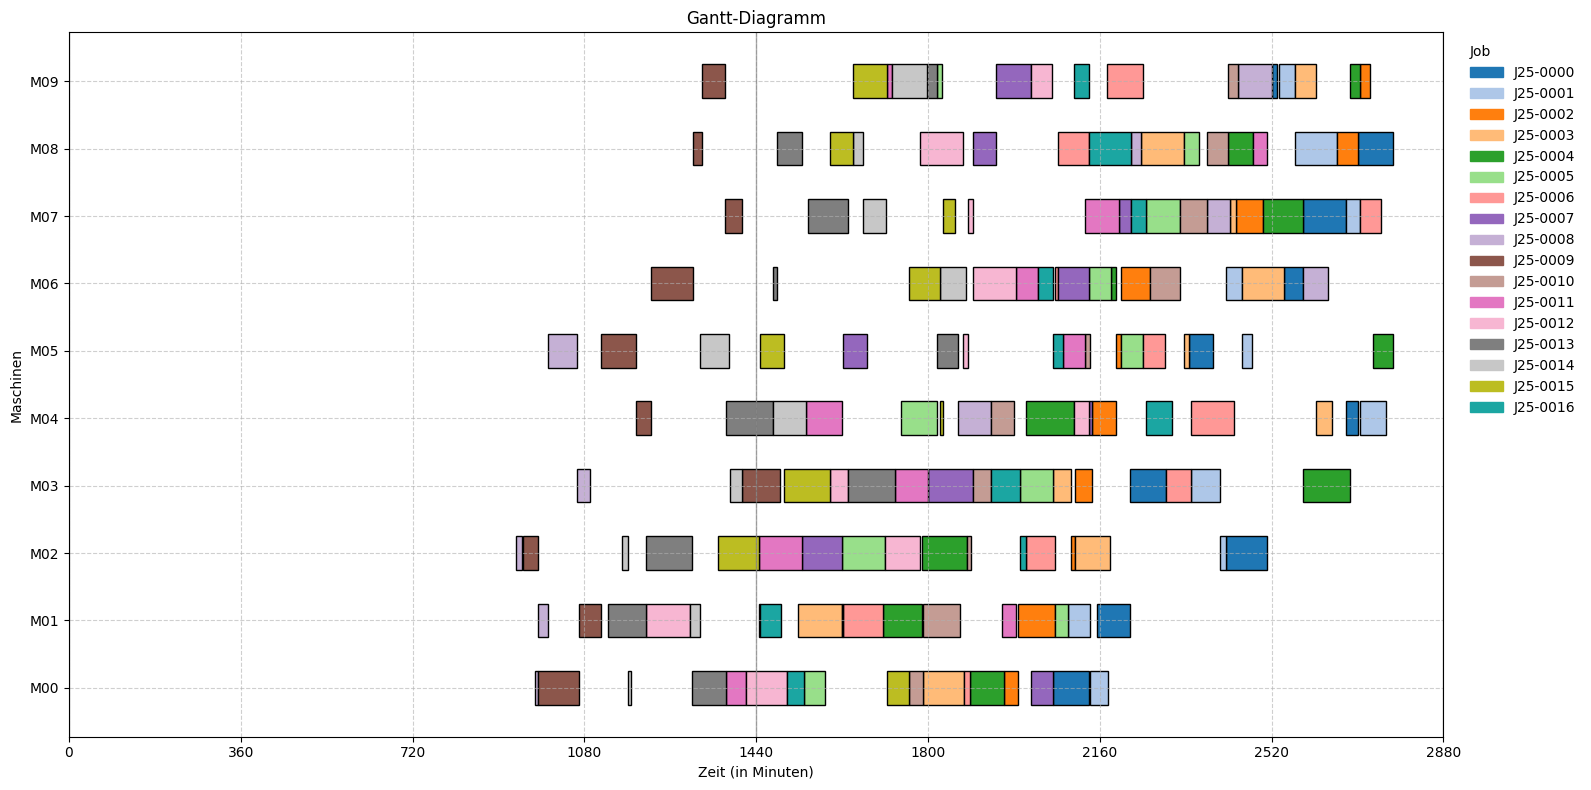

In [22]:
gantt.get_plot(df_schedule, perspective="Machine")

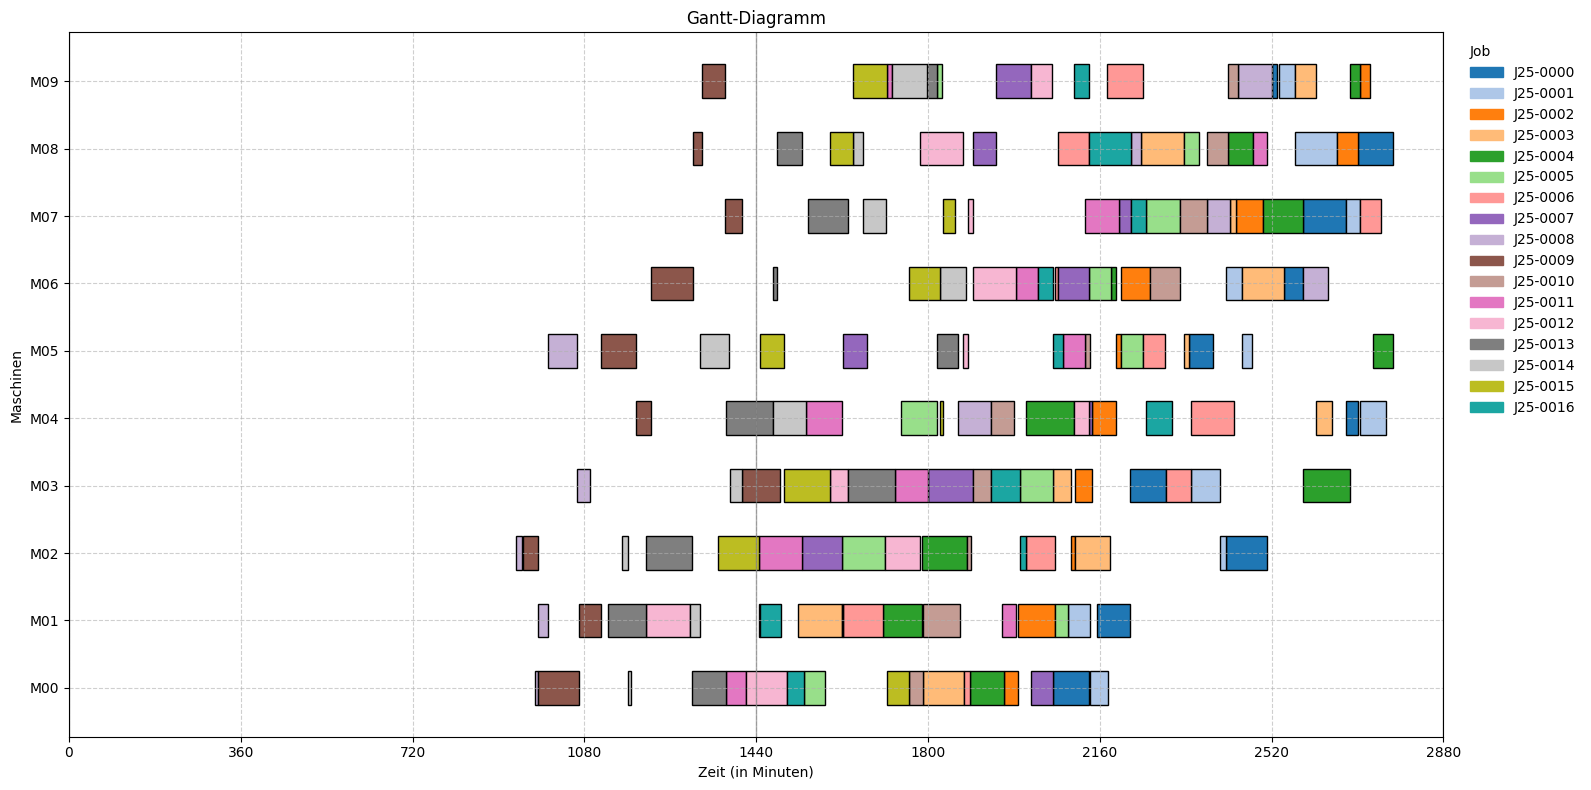

In [19]:
gantt.get_plot(df_schedule, perspective="Machine")

In [17]:
check.all_in_one(df_schedule_info)

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True